# FIRST ATTEMPT AT SRGANs


### Downloading dataset :

In [1]:
! wget https://webpages.tuni.fi/imaging/tampere17/tampere17_color.zip

--2023-09-11 17:59:38--  https://webpages.tuni.fi/imaging/tampere17/tampere17_color.zip
Resolving webpages.tuni.fi (webpages.tuni.fi)... 193.166.164.208
Connecting to webpages.tuni.fi (webpages.tuni.fi)|193.166.164.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146949619 (140M) [application/zip]
Saving to: ‘tampere17_color.zip’

tampere17_color.zip 100%[===================>] 140.14M  17.7MB/s    in 9.2s    

2023-09-11 17:59:48 (15.3 MB/s) - ‘tampere17_color.zip’ saved [146949619/146949619]



In [ ]:
!unzip tampere17_color.zip

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt



### Preparing the LR/HR pairs for training :

In [4]:
# Define the folder containing your images
folder_path = "/content/color"

# Define the output folders for high-resolution and low-resolution images
output_hr_folder = "/content/HR_images"
output_lr_folder = "/content/LR_images"

# Ensure the output folders exist, create them if necessary
os.makedirs(output_hr_folder, exist_ok=True)
os.makedirs(output_lr_folder, exist_ok=True)

# Iterate through the images in the folder
for img in os.listdir(folder_path):
    if img.endswith((".jpg", ".jpeg", ".png")):
        # Read the image
        img_path = os.path.join(folder_path, img)
        img_array = cv2.imread(img_path)

        # Resize the image to high-resolution
        hr_img_array = cv2.resize(img_array, (512, 512))

        # Resize the image to low-resolution
        lr_img_array = cv2.resize(img_array, (128, 128))
        mean = 0
        stddev = 180
        noise = np.zeros(lr_img_array.shape, np.uint8)
        cv2.randn(noise, mean, stddev)
        lr_img_array = cv2.add(lr_img_array, noise)
        # Save the high-resolution image
        cv2.imwrite(os.path.join(output_hr_folder, img), hr_img_array)

        # Save the low-resolution image
        cv2.imwrite(os.path.join(output_lr_folder, img), lr_img_array)

print("Resizing complete.")


Resizing complete.


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Displaying some LR/HR pairs :

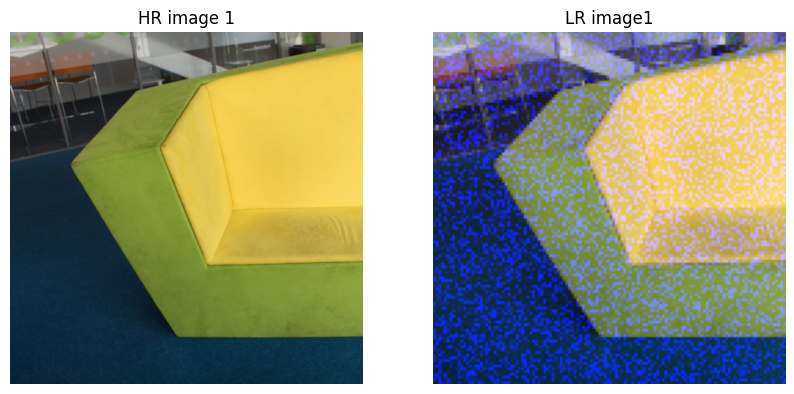

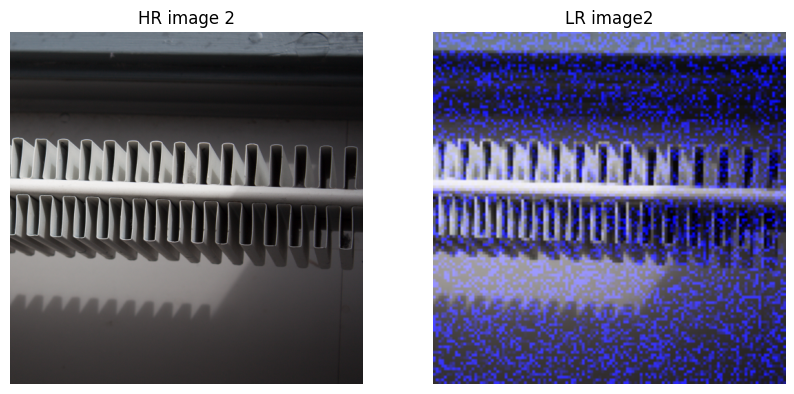

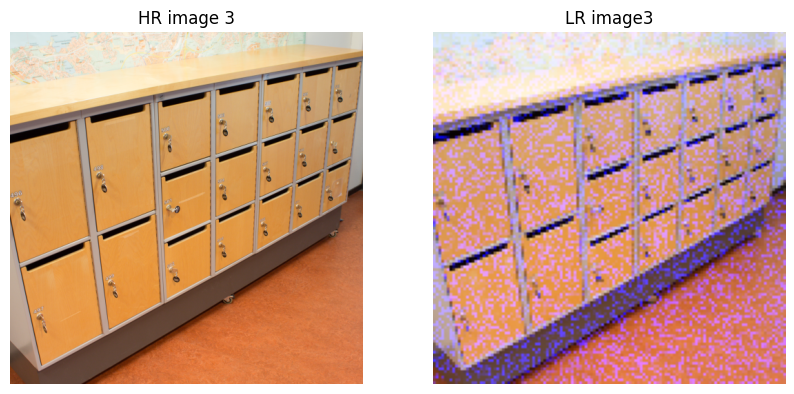

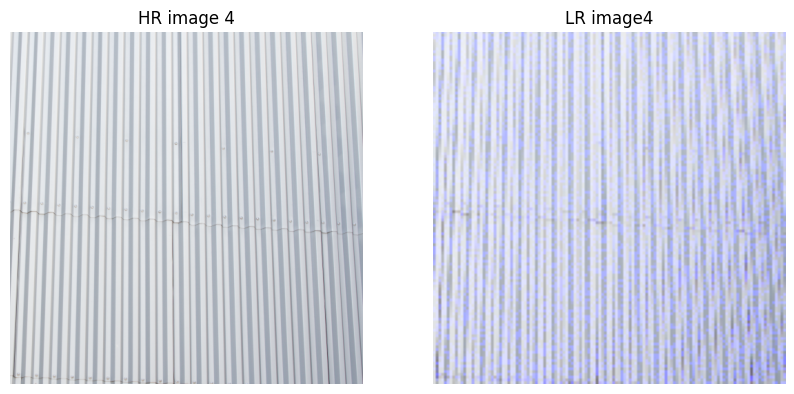

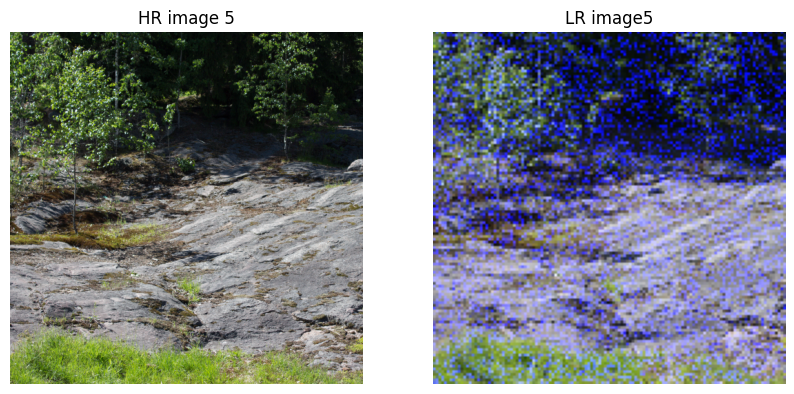

In [6]:
counter = 0
folder_path1 = "/content/HR_images"
folder_path2 = "/content/LR_images"
for img1,img2 in zip( os.listdir(folder_path1) , os.listdir(folder_path2) ) :
   if img1.endswith((".jpg", ".jpeg", ".png")) and img2.endswith((".jpg", ".jpeg", ".png")) :
    img_path1 = os.path.join(folder_path1, img1)
    img1 = mpimg.imread(img_path1)

    img_path2 = os.path.join(folder_path2, img2)
    img2 = mpimg.imread(img_path2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Display the first image in the first subplot
    ax1.imshow(img1)
    ax1.set_title('HR image ' + str(counter + 1))
    ax1.axis('off')

    # Display the second image in the second subplot
    ax2.imshow(img2)
    ax2.set_title('LR image'+ str(counter + 1))
    ax2.axis('off')

    counter += 1
    if counter == 5 :
      break

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

# BUIlDING THE GAN  


#### Defining The Building Blocks:

In [8]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#### Create The Generator Network :

In [9]:
def create_gen(gen_ip, num_res_block):
  layers = Conv2D(64, (9,9), padding="same")(gen_ip)
  layers = PReLU(shared_axes=[1,2])(layers)

  temp = layers

  for i in range(num_res_block):
      layers = res_block(layers)

  layers = Conv2D(64, (3,3), padding="same")(layers)
  layers = BatchNormalization(momentum=0.5)(layers)
  layers = add([layers,temp])

  layers = upscale_block(layers)
  layers = upscale_block(layers)

  op = Conv2D(3, (9,9), padding="same")(layers)

  return Model(inputs=gen_ip, outputs=op)

#### Create The Discriminator Network :

In [10]:
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#### Importing the VGG19 Model :
- We will be using the VGG19 object classificatier pretrained model to extract features from generated images (HR generated) and comapre them to the features of groud-truth images (HR)

In [11]:
from keras.applications import VGG19
def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


#### Combining the generator and the discriminator in a single model for training purposes :

In [12]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

#### Loading HR/LR pairs of images in two lists :
n : the number of training images , we will be using a subset of 5000 images from the training set for demo purposes.


In [13]:
n=100
lr_list = os.listdir("/content/LR_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/LR_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/HR_images")[:n]

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/HR_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


### Sanity check xd


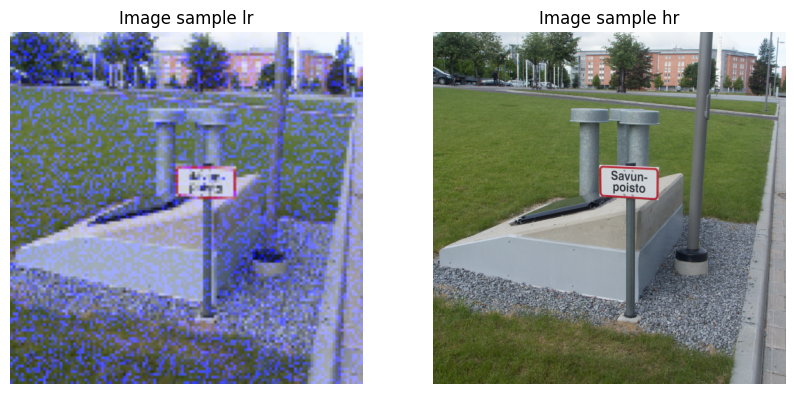

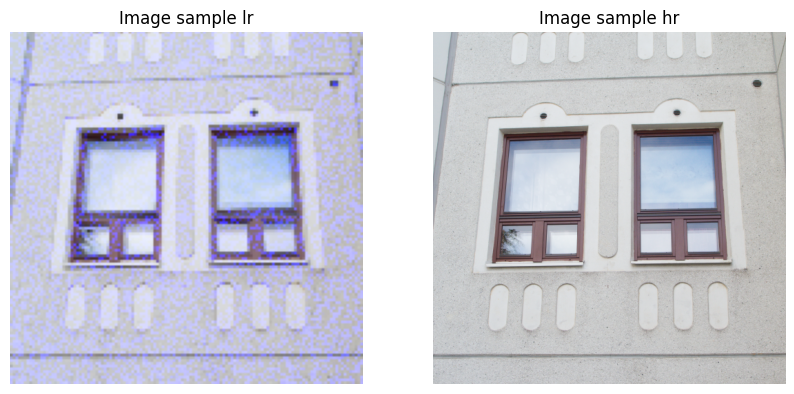

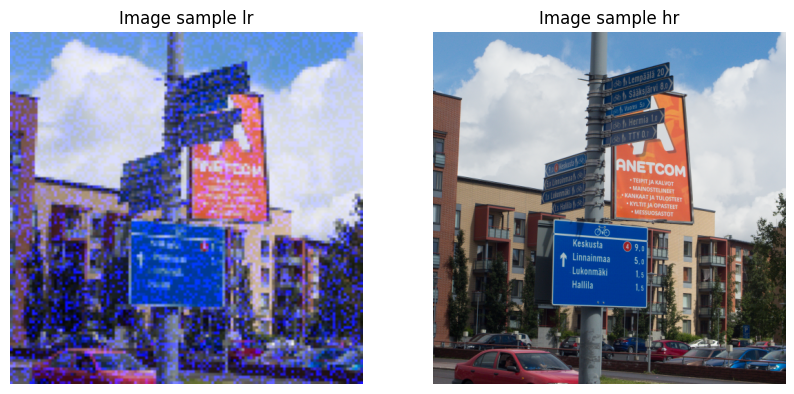

In [14]:
for i in range (3) :
  img_lr = lr_images[i+10]
  img_hr = hr_images[i+10]

  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

  # Display the first image in the first subplot
  ax1.imshow(img_lr)
  ax1.set_title('Image sample lr')
  ax1.axis('off')

  # Display the second image in the second subplot
  ax2.imshow(img_hr)
  ax2.set_title('Image sample hr')
  ax2.axis('off')

### 1-Scaling Values between 0 and 1
### 2-Splitting data into test and training data


In [15]:
def train_test_split (lr_images , hr_images , test_size ) :
  index = int (test_size * len(lr_images))
  lr_train =  lr_images[index : ]
  lr_test =  lr_images [: index ]
  hr_train = hr_images [index : ]
  hr_test = hr_images [:index ]
  return lr_train, lr_test , hr_train , hr_test

In [16]:

lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,test_size=0.33)

In [17]:

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
print(hr_shape)
print(lr_shape )

print(lr_train.shape ,hr_train.shape)
type(lr_train)

(512, 512, 3)
(128, 128, 3)
(67, 128, 128, 3) (67, 512, 512, 3)


numpy.ndarray

In [18]:

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg(hr_shape)
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 128, 128, 64)         64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['p_re_lu[0][0]']             
                                                                                              

In [19]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])



In [ ]:
epochs = 60
for e in range(epochs):
  fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
  real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

  #Create empty lists to populate gen and disc losses.
  g_losses = []
  d_losses = []

  #Enumerate training over batches.
  for b in tqdm(range(len(train_hr_batches))):
    lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
    hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

    fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

    #First, train the discriminator on fake and real HR images.
    discriminator.trainable = True
    d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
    d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

    #Now, train the generator by fixing discriminator as non-trainable
    discriminator.trainable = False

    #Average the discriminator loss, just for reporting purposes.
    d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

    #Extract VGG features, to be used towards calculating loss
    image_features = vgg.predict(hr_imgs)

    #Train the generator via GAN.
    #Remember that we have 2 losses, adversarial loss and content (VGG) loss
    g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

    #Save losses to a list so we can average and report.
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  #Convert the list of losses to an array to make it easy to average
  g_losses = np.array(g_losses)
  d_losses = np.array(d_losses)

  #Calculate the average losses for generator and discriminator
  g_loss = np.sum(g_losses, axis=0) / len(g_losses)
  d_loss = np.sum(d_losses, axis=0) / len(d_losses)

  #Report the progress during training.
  print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
      #Save the generator after every n epochs (Usually 10 epochs)
      generator.save("gen_e_"+ str(e+1) +".h5")




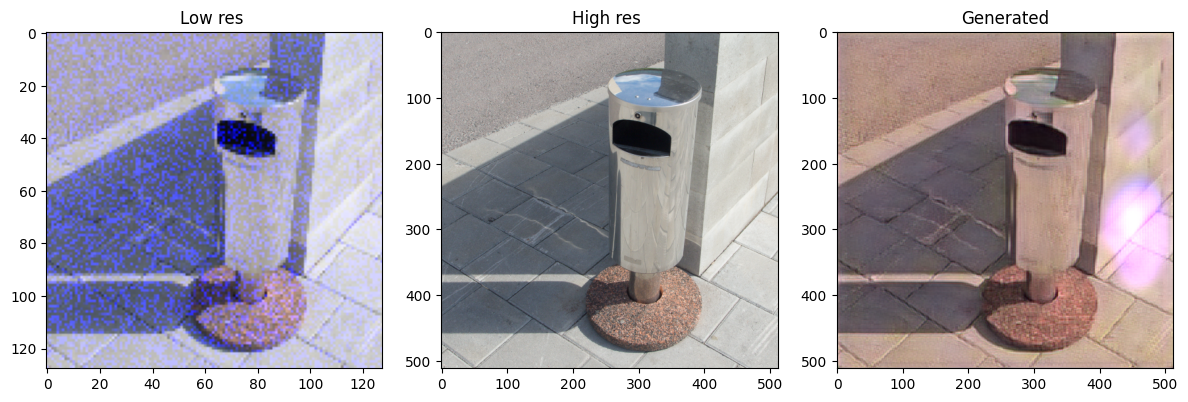

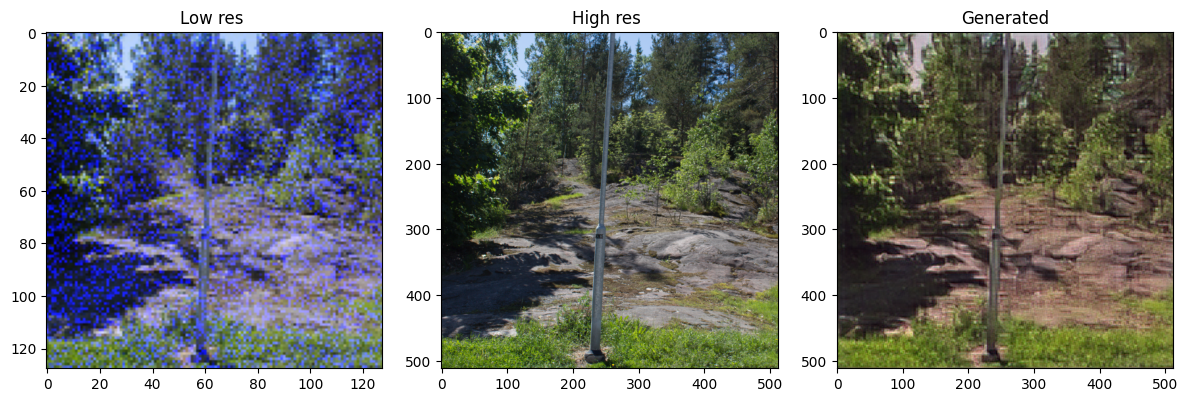

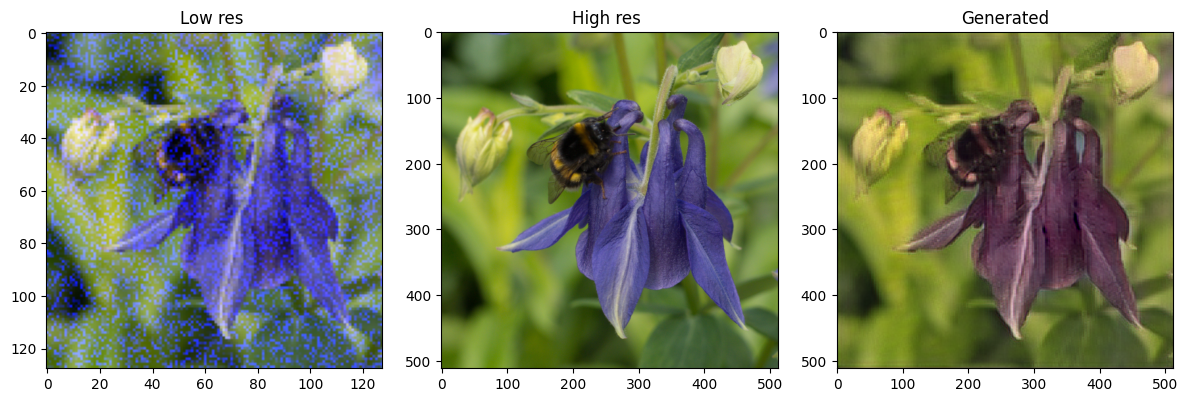

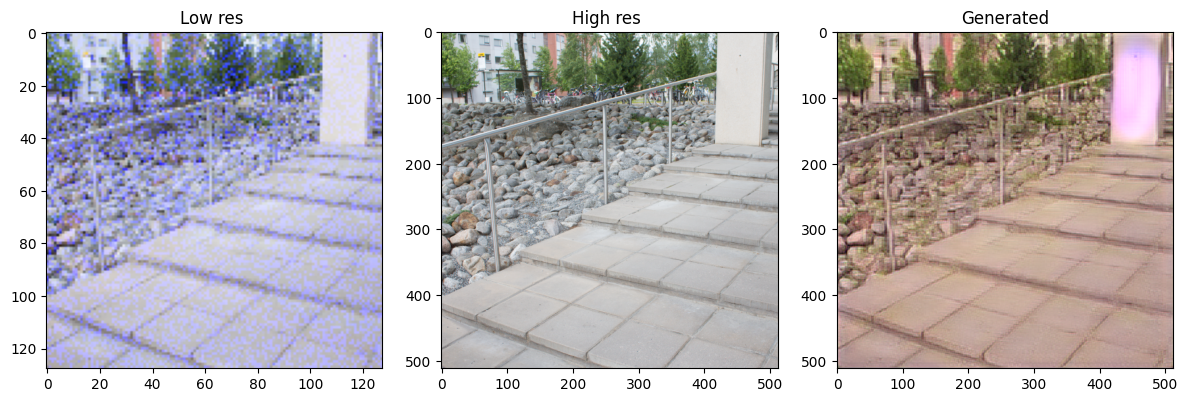

In [32]:
random_array = np.random.randint(0, 50, size= 4)
for index in random_array :
  low_res = train_lr_batches [index]
  ground_truth = train_hr_batches[index]
  generated = generator.predict_on_batch(low_res)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))


  axes[0].imshow(low_res[0])
  axes[0].set_title('Low res ')


  axes[1].imshow(ground_truth[0])
  axes[1].set_title('High res ')


  axes[2].imshow(generated[0])
  axes[2].set_title('Generated')


  plt.tight_layout()






